# Chess Sim2Real — **Ready-to-run inference** (Real photo → predicted FEN → synthetic board image)

This notebook is **self‑contained** (no missing globals).  
**Inputs:** a real chess image + your trained `.pt` checkpoint.  
**Outputs:** predicted FEN placement + a rendered synthetic chessboard image of the predicted state.


In [1]:
!pip -q install albumentations python-chess cairosvg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 130.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.2 MB/s eta 0:00:00


In [2]:
import os, io, math, random
from pathlib import Path
import cv2, numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision

import albumentations as A
from albumentations.pytorch import ToTensorV2

import chess
import chess.svg
import cairosvg
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

from sklearn.cluster import KMeans
from google.colab import files

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


In [3]:
CLASSES = ["empty","wP","wN","wB","wR","wQ","wK","bP","bN","bB","bR","bQ","bK"]

IDX2FEN = {
    0: None,
    1: "P", 2:"N", 3:"B", 4:"R", 5:"Q", 6:"K",
    7: "p", 8:"n", 9:"b", 10:"r", 11:"q", 12:"k"
}

def grid_to_fen_placement(grid_idx: np.ndarray) -> str:
    rows = []
    for r in range(8):
        run = 0
        out = ""
        for c in range(8):
            ch = IDX2FEN.get(int(grid_idx[r,c]), None)
            if ch is None:
                run += 1
            else:
                if run:
                    out += str(run)
                    run = 0
                out += ch
        if run:
            out += str(run)
        rows.append(out)
    return "/".join(rows)

def set_seed(seed=0):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)

In [4]:
class SquareClassifier(nn.Module):
    def __init__(self, num_classes: int, dropout: float = 0.2, backbone: str = "resnet18"):
        super().__init__()
        net = torchvision.models.resnet34(weights=None) if backbone == "resnet34" else torchvision.models.resnet18(weights=None)
        in_features = net.fc.in_features
        net.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_features, num_classes))
        self.net = net
    def forward(self, x):
        return self.net(x)

class EfficientNetSquareClassifier(nn.Module):
    def __init__(self, num_classes: int, dropout: float = 0.2):
        super().__init__()
        net = torchvision.models.efficientnet_b0(weights=None)
        in_features = net.classifier[1].in_features
        net.classifier[1] = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_features, num_classes))
        self.net = net
    def forward(self, x):
        return self.net(x)

def infer_model_type_from_state_dict(sd: dict) -> str:
    keys = list(sd.keys())
    if any(k.startswith("net.layer1.") or k.startswith("net.conv1.") for k in keys) or any(".layer1." in k for k in keys):
        return "resnet"
    if any(k.startswith("net.features.") for k in keys) or any(".features." in k for k in keys):
        return "efficientnet"
    return "unknown"

def load_checkpoint_flexible(path: str, num_classes: int) -> nn.Module:
    ckpt = torch.load(path, map_location="cpu", weights_only=False)
    sd = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt
    drop = float(ckpt.get("cfg", {}).get("dropout", 0.2)) if isinstance(ckpt, dict) else 0.2

    mtype = infer_model_type_from_state_dict(sd)
    if mtype == "efficientnet":
        model = EfficientNetSquareClassifier(num_classes=num_classes, dropout=drop)
    else:
        model = SquareClassifier(num_classes=num_classes, dropout=drop)

    incompatible = model.load_state_dict(sd, strict=False)
    print(f"[{os.path.basename(path)}] model_guess={mtype} | missing={len(incompatible.missing_keys)} unexpected={len(incompatible.unexpected_keys)}")
    return model.to(DEVICE).eval()


In [5]:
def build_transforms(train: bool, image_size: int = 96):
    if train:
        return A.Compose([
            A.Resize(image_size, image_size),
            A.RandomBrightnessContrast(p=0.15),
            A.GaussNoise(p=0.10),
            A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
            ToTensorV2(),
        ])

TF_EVAL = build_transforms(train=False, image_size=96)

In [6]:
def normalize_line(rho, theta):
    if rho < 0:
        rho = -rho
        theta = (theta + np.pi) % np.pi
    return float(rho), float(theta)

def extract_grid_masks(gray):
    g = cv2.GaussianBlur(gray, (5,5), 0)
    bw = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY_INV, 21, 5)
    H, W = bw.shape
    bw2 = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)), iterations=1)
    h_len = max(25, W // 14); v_len = max(25, H // 14)
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (h_len, 1))
    v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, v_len))
    h_mask = cv2.dilate(cv2.erode(bw2, h_kernel, iterations=1), h_kernel, iterations=2)
    v_mask = cv2.dilate(cv2.erode(bw2, v_kernel, iterations=1), v_kernel, iterations=2)
    return h_mask, v_mask

def hough_mask_lines(mask, is_horizontal):
    linesP = cv2.HoughLinesP(mask, rho=1, theta=np.pi/180, threshold=50,
                             minLineLength=40, maxLineGap=30)
    if linesP is None:
        return np.zeros((0,2), dtype=np.float32)
    out = []
    for x1,y1,x2,y2 in linesP[:,0]:
        dx, dy = (x2-x1), (y2-y1)
        ang = abs(math.degrees(math.atan2(dy, dx)))
        if is_horizontal:
            if ang > 10 and ang < 170:
                continue
            theta = np.pi/2
        else:
            if abs(ang - 90) > 10:
                continue
            theta = 0
        rho = x1*math.cos(theta) + y1*math.sin(theta)
        out.append(normalize_line(rho, theta))
    return np.array(out, dtype=np.float32)

def cluster_to_9_lines(lines):
    if len(lines) < 20:
        raise RuntimeError(f"Too few candidate lines: {len(lines)}")
    L = np.array([normalize_line(r,t) for r,t in lines], dtype=np.float32)
    rhos = L[:,0].reshape(-1,1)
    km = KMeans(n_clusters=9, n_init="auto", random_state=0).fit(rhos)
    labels = km.labels_
    reps = []
    for k in range(9):
        group = L[labels == k]
        reps.append((float(np.median(group[:,0])), float(np.mean(group[:,1]))))
    reps.sort(key=lambda x: x[0])
    return reps

def x_at_y(line, y):
    rho, t = line
    c, s = math.cos(t), math.sin(t)
    if abs(c) < 1e-9:
        return None
    return (rho - y*s) / c

def y_at_x(line, x):
    rho, t = line
    c, s = math.cos(t), math.sin(t)
    if abs(s) < 1e-9:
        return None
    return (rho - x*c) / s

def sort_vertical_lines_left_to_right(v_lines, img_h):
    ymid = img_h / 2.0
    scored = []
    for line in v_lines:
        xv = x_at_y(line, ymid)
        if xv is not None and np.isfinite(xv):
            scored.append((xv, line))
    scored.sort(key=lambda z: z[0])
    return [l for _, l in scored]

def sort_horizontal_lines_top_to_bottom(h_lines, img_w):
    xmid = img_w / 2.0
    scored = []
    for line in h_lines:
        yh = y_at_x(line, xmid)
        if yh is not None and np.isfinite(yh):
            scored.append((yh, line))
    scored.sort(key=lambda z: z[0])
    return [l for _, l in scored]

def intersect(l1, l2):
    rho1, th1 = l1; rho2, th2 = l2
    A = np.array([[math.cos(th1), math.sin(th1)],
                  [math.cos(th2), math.sin(th2)]], dtype=np.float64)
    b = np.array([rho1, rho2], dtype=np.float64)
    if abs(np.linalg.det(A)) < 1e-10:
        return None
    x, y = np.linalg.solve(A, b)
    if not (np.isfinite(x) and np.isfinite(y)):
        return None
    return np.array([x,y], dtype=np.float64)

def _fit_homography_from_9x9_lines(gray, board_px=512):
    Himg, Wimg = gray.shape[:2]
    h_mask, v_mask = extract_grid_masks(gray)
    h_candidates = hough_mask_lines(h_mask, True)
    v_candidates = hough_mask_lines(v_mask, False)
    if len(h_candidates) < 9 or len(v_candidates) < 9:
        return None
    h9 = sort_horizontal_lines_top_to_bottom(cluster_to_9_lines(h_candidates), Wimg)
    v9 = sort_vertical_lines_left_to_right(cluster_to_9_lines(v_candidates), Himg)
    src_pts, dst_pts = [], []
    for i, h in enumerate(h9):
        for j, v in enumerate(v9):
            p = intersect(h, v)
            if p is None:
                continue
            x,y = p
            if x < -0.02*Wimg or x > 1.02*Wimg or y < -0.02*Himg or y > 1.02*Himg:
                continue
            src_pts.append([x,y]); dst_pts.append([j,i])
    src_pts = np.asarray(src_pts, np.float32)
    dst_pts = np.asarray(dst_pts, np.float32)
    if len(src_pts) < 70:
        return None
    H_grid, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=1.5)
    if H_grid is None:
        return None
    S = np.array([[board_px/8.0, 0, 0],
                  [0, board_px/8.0, 0],
                  [0, 0, 1]], dtype=np.float64)
    return S @ H_grid

def preprocess_board_real(img_bgr, out_size=512, fallback=True):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    H_px = _fit_homography_from_9x9_lines(gray, board_px=out_size)
    if H_px is not None:
        return cv2.warpPerspective(img_bgr, H_px, (out_size, out_size)), {"method":"hough_grid"}
    if fallback:
        h,w = img_bgr.shape[:2]
        s = min(h,w)
        crop = img_bgr[(h-s)//2:(h+s)//2, (w-s)//2:(w+s)//2].copy()
        return cv2.resize(crop, (out_size,out_size), interpolation=cv2.INTER_AREA), {"method":"fallback_center"}
    return cv2.resize(img_bgr, (out_size,out_size)), {"method":"failed"}

In [7]:
def crop_context_square_from_board(board_bgr, r, c, k=1.6, out_size=96):
    S = board_bgr.shape[0]
    sq = S / 8.0
    cx = (c + 0.5) * sq
    cy = (r + 0.5) * sq
    side = float(k) * float(sq)
    half = 0.5 * side
    xa = int(round(cx - half)); xb = int(round(cx + half))
    ya = int(round(cy - half)); yb = int(round(cy + half))
    xa = max(0, min(S-2, xa)); ya = max(0, min(S-2, ya))
    xb = max(xa+1, min(S-1, xb)); yb = max(ya+1, min(S-1, yb))
    patch = board_bgr[ya:yb, xa:xb]
    interp = cv2.INTER_CUBIC if out_size > max(patch.shape[:2]) else cv2.INTER_AREA
    return cv2.resize(patch, (out_size,out_size), interpolation=interp)

def extract_64_cubes(board_bgr, cube_size=96, k=1.6):
    return np.stack([crop_context_square_from_board(board_bgr, r, c, k=k, out_size=cube_size)
                     for r in range(8) for c in range(8)], axis=0)

In [9]:
UNICODE_PIECES = {
    "wP": "♙", "wN": "♘", "wB": "♗", "wR": "♖", "wQ": "♕", "wK": "♔",
    "bP": "♟", "bN": "♞", "bB": "♝", "bR": "♜", "bQ": "♛", "bK": "♚",
    "empty": ""
}

def render_grid_image(grid, square_px=160, font_path=None):
    """
    grid: (8,8) ints -> class index into CLASSES
    square_px: make bigger to see clearly
    font_path: support chess symbols
    """
    assert font_path is not None, "Pass font_path."

    img = Image.new("RGB", (8*square_px, 8*square_px), "white")
    draw = ImageDraw.Draw(img)

    font = ImageFont.truetype(font_path, int(square_px * 0.82))

    for r in range(8):
        for c in range(8):
            x0, y0 = c*square_px, r*square_px
            x1, y1 = x0 + square_px, y0 + square_px

            light = (240, 217, 181)
            dark  = (181, 136,  99)
            draw.rectangle([x0, y0, x1, y1], fill=(light if (r+c)%2==0 else dark))

            cls = CLASSES[int(grid[r, c])]
            sym = UNICODE_PIECES.get(cls, "")

            if sym:
                # center text
                bbox = draw.textbbox((0,0), sym, font=font)
                w = bbox[2] - bbox[0]
                h = bbox[3] - bbox[1]
                draw.text(
                    (x0 + (square_px - w)//2, y0 + (square_px - h)//2 - int(square_px*0.05)),
                    sym,
                    fill=(0,0,0),
                    font=font
                )
    return np.array(img)

In [10]:
!wget -q https://github.com/dejavu-fonts/dejavu-fonts/raw/master/ttf/DejaVuSans.ttf -O /content/DejaVuSans.ttf
!ls -l /content/DejaVuSans.ttf


-rw-r--r-- 1 root root 0 Jan 19 22:22 /content/DejaVuSans.ttf


In [11]:
# ENSURE CHESS-CAPABLE FONT EXISTS
!apt-get update -y >/dev/null
!apt-get install -y fonts-dejavu-core >/dev/null

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [12]:
def show_board_with_grid(board_bgr, title="Warped board + grid"):
    h, w = board_bgr.shape[:2]
    assert h == w, f"Board not square: {h}x{w}. Fix warp/resize to (N,N)."
    S = h
    step = S / 8.0

    vis = board_bgr.copy()

    # draw grid lines
    for i in range(9):
        x = int(round(i * step))
        y = int(round(i * step))
        cv2.line(vis, (x, 0), (x, S-1), (0, 255, 0), 1)
        cv2.line(vis, (0, y), (S-1, y), (0, 255, 0), 1)

    vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(vis_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [13]:
def show_crops_mosaic(crops_bgr, title="64 crops (8x8)"):
    assert len(crops_bgr) == 64
    # convert each crop to RGB for display
    crops_rgb = [cv2.cvtColor(p, cv2.COLOR_BGR2RGB) for p in crops_bgr]

    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(crops_rgb[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [14]:
files = "abcdefgh"

def idx_from_square(square: str) -> int:
    f = files.index(square[0].lower())
    r = int(square[1]) - 1
    return (7 - r) * 8 + f

def show_square_crop(crops_bgr, square: str):
    i = idx_from_square(square)
    img_rgb = cv2.cvtColor(crops_bgr[i], cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(3,3))
    plt.imshow(img_rgb)
    plt.title(f"{square} (idx={i})")
    plt.axis("off")
    plt.show()

Step 1: Upload ONE checkpoint .pt (best_train.pt)
best_train.pt size: 134316009 bytes
✅ Checkpoint saved: /content/best_train.pt

Step 2: Upload one or more images


Saving frame_028200.jpg to frame_028200 (2).jpg
Saving frame_038416.jpg to frame_038416 (2).jpg
[best_train.pt] model_guess=resnet | missing=0 unexpected=0
✅ Model loaded on cuda


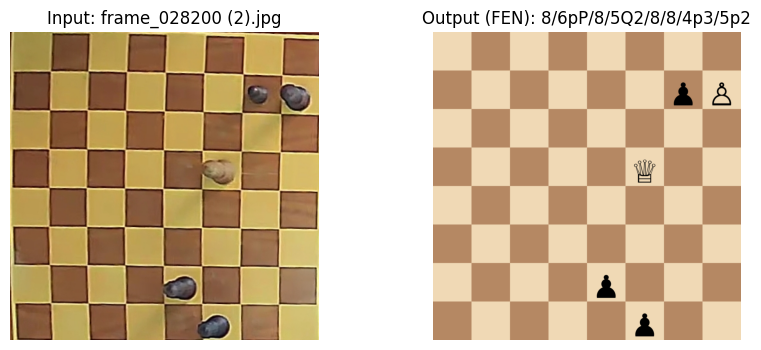

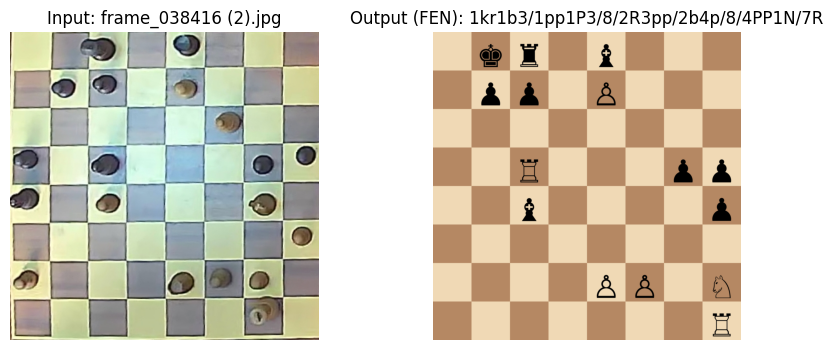

In [22]:
# INFERENCE
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
assert os.path.isfile(FONT_PATH), "DejaVuSans.ttf not found"
_ = ImageFont.truetype(FONT_PATH, 32)

print("Step 1: Upload ONE checkpoint .pt (best_train.pt)")
uploaded_pt = files.upload()
assert len(uploaded_pt) == 1, "Please upload exactly ONE .pt file."
ckpt_name, ckpt_bytes = next(iter(uploaded_pt.items()))
ckpt_path = os.path.join("/content", ckpt_name)
with open(ckpt_path, "wb") as f:
    f.write(ckpt_bytes)
print("Checkpoint saved:", ckpt_path)

print("\nStep 2: Upload one or more images")
uploaded_imgs = files.upload()
assert len(uploaded_imgs) >= 1, "Please upload at least one image."

model = load_checkpoint_flexible(ckpt_path, num_classes=len(CLASSES)).to(DEVICE).eval()
print("Model loaded on", DEVICE)

@torch.no_grad()
def predict_grid(model, X):
    preds = model(X).argmax(dim=1)
    return preds.detach().cpu().numpy().reshape(8, 8)

def fen_from_grid(grid):
    # Convert 8x8 class grid -> FEN placement string using CLASSES labels
    rows = []
    for r in range(8):
        empties = 0
        parts = []
        for c in range(8):
            cls = CLASSES[int(grid[r, c])]
            if cls == "empty":
                empties += 1
            else:
                if empties:
                    parts.append(str(empties))
                    empties = 0
                piece = cls[1]
                parts.append(piece.upper() if cls[0] == "w" else piece.lower())
        if empties:
            parts.append(str(empties))
        rows.append("".join(parts))
    return "/".join(rows)

def show_input_and_output(input_bgr, pred_grid, title_left, title_right):
    out_img = render_grid_image(pred_grid, square_px=180, font_path=FONT_PATH)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(input_bgr, cv2.COLOR_BGR2RGB))
    plt.title(title_left)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(out_img)
    plt.title(title_right)
    plt.axis("off")
    plt.show()

# Run for each uploaded image
for idx, (img_name, img_bytes) in enumerate(uploaded_imgs.items(), start=1):
    arr = np.frombuffer(img_bytes, dtype=np.uint8)
    img_bgr = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    assert img_bgr is not None, f"Failed decoding image: {img_name}"

    # Warp & preprocess board
    board_bgr, dbg = preprocess_board_real(img_bgr, out_size=512, fallback=True)

    # Extract 64 crops and build model batch
    cubes = extract_64_cubes(board_bgr, cube_size=96, k=1.6)
    cubes_rgb = np.stack([cv2.cvtColor(p, cv2.COLOR_BGR2RGB) for p in cubes], axis=0)
    X = torch.stack([TF_EVAL(image=cubes_rgb[i])["image"] for i in range(64)], dim=0).to(DEVICE)

    grid = predict_grid(model, X)
    fen_place = fen_from_grid(grid)

    show_input_and_output(
        img_bgr,
        grid,
        title_left=f"Input: {img_name}",
        title_right=f"Output (FEN): {fen_place}"
    )
